In [88]:
# Setup environment
from spacepy import pycdf
import spacepy.time as spt
import spacepy.coordinates as spc
import spacepy.irbempy as ib

import numpy as np

import numpy as np
import matplotlib.dates as md
import spacepy.time as spt
import datetime

import netCDF4

import matplotlib.pyplot as plt

import os

In [89]:
dateStringA = "2015-09-07"
dateStringB = dateStringA.replace('-', '')

# Currently loads and saves everything to the directory that this file is in
topDir = f'{os.getcwd()}\\'


# modelStrs = ["IGRF_T89", "IGRF_0"]
models = ["T89", "0"]

# Where to save the CDF
saveDir = f'{os.getcwd()}\\'

stepSize = 0.01 # Re

# Will only calculate one in every skipcount L-shells, and will linearly interpolate the rest to decrease runtime
# Currently not fully implemented, and only skipCount = 1 will function
skipCount = 1 

earthR = 6378 # km
# Opens the cdf to write
try:
    saveCDF = pycdf.CDF(f'{saveDir}L_Data_{dateStringB}.cdf', '')
except pycdf.CDFError:
    saveCDF = pycdf.CDF(f'{saveDir}L_Data_{dateStringB}.cdf')
    saveCDF.readonly(False)

In [90]:
# Spacecraft class holds a CDF object, a name, and whether it is an Allen probe or not
# This lets both Allen Probes and DMSP probes be treated as essentially the same object
class Spacecraft:
    def __init__(self, CDF, scName, isAllen = False):
        self.CDF = CDF
        self.scName = scName
        self.isAllen = isAllen

In [91]:
allSC = np.zeros(0)
# Loads up the cdf file
for scNameAllen in ['rbspa']:#, 'rbspb']:
    # Data source: https://rbsp.space.umn.edu/data/rbsp/rbspa/l3/2015/
    fileNameAllenCDF = f'{scNameAllen}_efw-l3_{dateStringB}_v01.cdf'
    CDF = pycdf.CDF(topDir+fileNameAllenCDF)
    allSC = np.append(allSC, Spacecraft(CDF, scNameAllen, isAllen = True))
    print(CDF)

# Currently does not load up any DMSP probes because testing focuses on
# making sure than an Allen probe works
for DMSPID in range(15, 15): #20):
    # Data source: http://cedar.openmadrigal.org/docs/name/rt_python.html
    fileNameDMSP = f'dms_{dateStringB}_{DMSPID}s1.001.nc'
    CDF = netCDF4.Dataset(topDir+fileNameDMSP,'r')
    allSC = np.append(allSC, Spacecraft(CDF, f'DMSP{DMSPID}'))
    print(CDF.variables.keys())

Bfield_LABL_1: CDF_CHAR*27 [11] NRV
EFW_QUAL_GOOD: CDF_INT2 [] NRV
EFW_QUAL_NR: CDF_INT2 [] NRV
EFW_QUAL_UNK: CDF_INT2 [] NRV
Vavg: CDF_REAL4 [7751]
VcoroxB_mgse: CDF_REAL4 [7751, 3]
VscxB_mgse: CDF_REAL4 [7751, 3]
angle_Ey_Ez_Bo_LABL_1: CDF_CHAR*29 [2] NRV
bfield_labl: CDF_CHAR*12 [3] NRV
bfield_minus_model_labl: CDF_CHAR*27 [3] NRV
bias_current_LABL_1: CDF_CHAR*27 [6] NRV
bias_flag_labl: CDF_CHAR*9 [2] NRV
charging_flag_labl: CDF_CHAR*13 [2] NRV
coro_labl: CDF_CHAR*19 [3] NRV
density: CDF_REAL4 [7751]
density_potential_LABL_1: CDF_CHAR*32 [8] NRV
eclipse_flag_labl: CDF_CHAR*12 [2] NRV
efield_corotation_frame_mgse: CDF_REAL4 [7751, 3]
efield_inertial_frame_mgse: CDF_REAL4 [7751, 3]
efw_qual_compno: CDF_INT2 [20] NRV
efw_qual_labl: CDF_CHAR*19 [20] NRV
ephemeris_LABL_1: CDF_CHAR*28 [14] NRV
epoch: CDF_EPOCH16 [7751]
esvy_labl: CDF_CHAR*3 [3] NRV
flag_labl: CDF_CHAR*16 [3] NRV
flags_all: CDF_REAL4 [7751, 20]
flags_charging_bias_eclipse: CDF_REAL4 [7751, 3]
gse_pos_labl: CDF_CHAR*7 [3] N

In [92]:
# Takes a 1D array of datetime objects, a 2D array of position vectors,
# and a string for the external model type,
# and is intended to return a 1D array of L-shell vectors,
# either calculated from spacepy's get_Lm function if selfTrace = False
# or calculated through field line tracing if selfTrace = True
# Currently traceL returns a curve object for debugging and plotting purposes
def calculateL(times, positions, extModel, selfTrace = False):
    if not selfTrace:
        coords = spc.Coords(positions, 'GSE', 'car', use_irbem=True)
        ticks = spt.Ticktock(times, 'ISO')
        return np.abs(ib.get_Lm(ticks, coords, 90, intMag = 'IGRF', extMag = extModel)['Lm'][:, 0])
    
    # Spacepy functions run the fastest when large sets of position and time data are 
    # passed in compared to running the function many times with small sets of data.
    # Therefore, we create a double-array of all of the spacecraft times/positions,
    # and trace each half of the array in a different direction from the spacecraft
    doubleTicks = spt.Ticktock(np.concatenate((times, times)), 'ISO')
    doublePos = np.concatenate((positions, positions))
    return traceL(doubleTicks, doublePos, extModel)

# Takes in a 1D array of spacepy ticks objects, a 2D array of position vectors,
# and a string for the external field model type
# and is intended to return a 1D array of L-shell values
# but currently returns 2 curve objects for debugging plotting purposes
def traceL(ticks, positions, extModel):
    actualSize = int(len(ticks)/2)

    # Array which holds the indices of all active field lines
    # these indices are removed as the field lines that they refer go
    # outside of the max radius or inside the min radius
    indices = np.array(range(0, len(ticks)))

    # Want to trace both directions from the spacecraft - see above for reason
    direction = np.concatenate((np.ones(actualSize), -1*np.ones(actualSize)))
    maxR = np.zeros(len(ticks))

    progressPercent = np.linspace(0, 100, 11)
    progressInd = 0

    while len(indices) > 0:
        if 100-len(indices)/(actualSize*2)*100 >= progressPercent[progressInd]:
            print(f"{progressPercent[progressInd]:0.0f}% done!")
            progressInd += 1
        
        positions[indices] = updateCoords(ticks[indices], positions[indices], extModel, direction[indices])
        radius = magnitude2D(positions[indices])

        maxR[indices] = np.max((maxR[indices], radius), axis=0)
        
        # Removes indices that are outside of the range
        # Typically it would be 1 instead of 1.6 for the minimum value
        # but the tracer gets stuck around 1.5 Re in an infinite loop currently
        destroyInd = [i for i in range(0, len(radius)) if (radius[i] >= 10 or radius[i] <= 1.6)]
        indices = np.delete(indices, destroyInd)
    
    print(f"{progressPercent[-1]:0.0f}% done!")
    return np.max((maxR[:int(actualSize)], maxR[:int(actualSize)]), axis=0)

# Takes a spacepy ticks variable, 2D positional vector, a string representing the 
# external model to use, and a 1D array containing 1 and -1 directions
# Returns the positional vector modified by taking a step of 1 stepSize towards along the 
# field line in the direction specified by the direction array
def updateCoords(ticks, positions, extModel, direction):

    coords = spc.Coords(positions, 'GEO', 'car', use_irbem=True)

    Bvec = np.array(ib.get_Bfield(ticks, coords, extMag=extModel)['Bvec'][:])

    # Reshaping to make each array a column array so it can be multiplied to the 2D array
    magnitude = np.reshape(magnitude2D(Bvec), (-1, 1))
    direction = np.reshape(direction, (-1, 1))

    dR = stepSize*direction*Bvec/magnitude

    return np.add(dR, positions)

# Takes a 2D array of vectors and returns a 
# 1D array of each individual vector magnitude
def magnitude2D(vec):
    return np.array([np.sqrt(vec[n].dot(vec[n])) for n in range(0, len(vec))])

In [93]:
for n in range(0, len(allSC)):
    isAllen = allSC[n].isAllen
    if isAllen:

        # This removed code is the intended function, but currently takes
        # extremely long due to the issue of the spiraling field lines

        getArr = range(0, len(allSC[n].CDF['epoch'][:]), skipCount)
        times = allSC[n].CDF['epoch'][:][getArr]
        coordsGSE = np.array(np.divide(allSC[n].CDF['pos_gse'][:], earthR))[getArr]
        coordsGSE = spc.Coords(coordsGSE, 'GSE', 'car', use_irbem=True)
        coordsGSE.ticks = spt.Ticktock(times, 'ISO')
        positions = coordsGSE.convert('GEO', 'car').data

        L = allSC[n].CDF['mlt_lshell_mlat'][getArr, 1]
        saveCDF[f'L_dipole_{allSC[n].scName}_Re'] = L
    
    # DMSP probe tracing
    else:
        getArr = range(0, len(allSC[n].CDF['epoch'][:]), skipCount)
        # Makes the array smaller if needed

        times = spt.Ticktock(allSC[n].CDF['timestamps'][getArr], 'UNX').UTC
        # Takes all of the values as n by 1 2D arrays and then concatenates them to be an n by 3 array of points
        gdalt, gdlat, glon = allSC[n].CDF['gdalt'][:].reshape(-1, 1), allSC[n].CDF['gdlat'][:].reshape(-1, 1), allSC[n].CDF['glon'][:].reshape(-1, 1)
        posGDZ = np.concatenate((gdalt, gdlat, glon), axis=1)
        coordsGDZ = spc.Coords(posGDZ, 'GDZ', 'sph', use_irbem=True)
        coordsGDZ.ticks = spt.Ticktock(times, 'ISO')
        postions = coordsGDZ.convert('GEO', 'car').data


        L = 1/pow(np.cos(np.pi*allSC[n].CDF["mlat"][getArr]/180),2)
        saveCDF[f'L_dipole_{allSC[n].scName}_Re'] = L
    
    print(f'{allSC[n].scName} time difference per step: {times[1]-times[0]}')

    saveCDF[f'Epoch_{allSC[n].scName}'] = times
    

    for i in range(0, len(models)):
        print(f"Calculating {models[i]} for {allSC[n].scName}.")
        L = calculateL(times, positions, models[i], selfTrace = True)
        saveCDF[f'L_{models[i]}_{allSC[n].scName}_Re'] = L
        Lcalc = calculateL(times, positions, models[i], selfTrace = False)
        saveCDF[f'L_calc_{models[i]}_{allSC[n].scName}_Re'] = Lcalc

saveCDF.close()

rbspa time difference per step: 0:00:11.139775
Calculating T89 for rbspa.
0% done!
10% done!
20% done!
30% done!
40% done!
50% done!
60% done!
70% done!
80% done!
90% done!
100% done!
Calculating 0 for rbspa.
0% done!
10% done!
20% done!
30% done!
40% done!
50% done!
60% done!
70% done!
80% done!
90% done!
100% done!


Epoch_rbspa: CDF_TIME_TT2000 [7751]
L_0_rbspa_Re: CDF_DOUBLE [7751]
L_T89_rbspa_Re: CDF_DOUBLE [7751]
L_calc_0_rbspa_Re: CDF_DOUBLE [7751]
L_calc_T89_rbspa_Re: CDF_DOUBLE [7751]
L_dipole_rbspa_Re: CDF_FLOAT [7751]

[6.2138433 6.212749  6.211655  ... 4.807181  4.81062   4.814059 ]
[6.2138433 6.212749  6.211655  ... 4.807181  4.81062   4.814059 ]


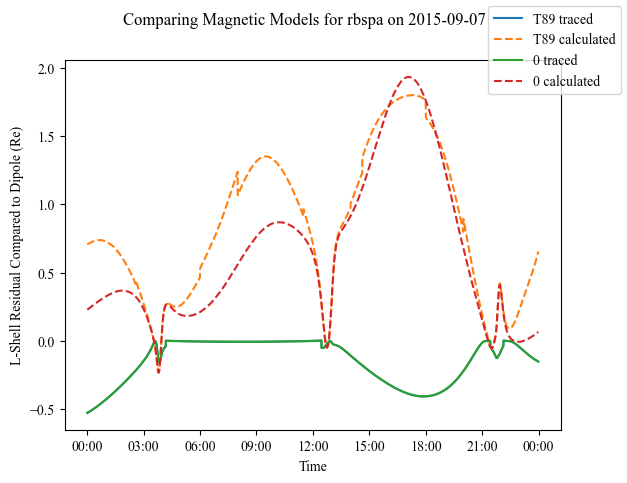

In [98]:
# The remaining code is only for testing
saveCDF = pycdf.CDF(f'{saveDir}L_Data_{dateStringB}.cdf')
# These remaining cells are for testing only

print(f'{saveCDF}\n')

# sets up the plot
plt.rcParams['font.family'] = 'Times New Roman'

for theSC in allSC:
    scName = theSC.scName
    fig = plt.figure()
    axs = fig.add_subplot()

    fig.suptitle(f'Comparing Magnetic Models for {scName} on {dateStringA}')

    if theSC.isAllen:
        dipoleL = theSC.CDF['mlt_lshell_mlat'][:, 1]
    else:
        dipoleL = 1/pow(np.cos(np.pi*theSC.CDF['mlat'][:]/180),2)
        plt.ylim((-6, 6))
        #axs.set_yscale('log')
    
    dipoleL = saveCDF[f'L_dipole_{theSC.scName}_Re'][:]


    for i in range(0, len(models)):
        axs.plot(saveCDF[f'Epoch_{scName}'][:], saveCDF[f'L_{models[i]}_{theSC.scName}_Re'][:]-dipoleL, label=f"{models[i]} traced")
        axs.plot(saveCDF[f'Epoch_{scName}'][:], saveCDF[f'L_calc_{models[i]}_{theSC.scName}_Re'][:]-dipoleL, label=f"{models[i]} calculated", linestyle="--")
    

    #axs.plot(saveCDF[f'Epoch_{scName}'][:], dipoleL, label = "Dipole")

    axs.set(xlabel = 'Time', ylabel='L-Shell Residual Compared to Dipole (Re)')

    fig.legend()

    # %Y-%m-%d %H:%M:%S
    xfmt = md.DateFormatter('%H:%M')
    axs.xaxis.set_major_formatter(xfmt)

    

    plt.draw()

saveCDF.close()
